# Filter Data
The divergence level is the outer threshold after which returns shouldn't go for a count to be valid

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

import sys
from pathlib import Path

stabilvol_path = Path("../stabilvol").resolve()
if str(stabilvol_path) not in sys.path:
    sys.path.append("../stabilvol")
    
from utility.classes.data_extraction import DataExtractor 
from utility import functions as f


MARKETS = [
    'UW', 'UN', 'LN', 'JT'
]
DATABASE = Path("../data/processed/trapezoidal_selection/stabilvol.sqlite")
if not DATABASE.is_file():
    print(f"Database file {DATABASE} does not exist.")

MARKETS = ["UN", "UW", "LN", "JT"]
START_LEVELS = [
    -2.0, 
    -1.0, -0.5, 
    -0.2, -0.1, 0.1, 0.2, 
    0.5, 1.0, 
    2.0
    ]
DELTAS = [
    2.0, 
    1.0, 0.5, 
    0.2, 0.1, -0.1, -0.2, 
    -0.5, -1.0, 
    -2.0
    ]
LEVELS = sorted({
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
})
LEVELS = sorted(LEVELS)

VOL_LIMIT= 1  # Change this will change all the pickle files, remember to re-generate them
len(LEVELS)

100

In [2]:
def query_fht_series(conn, market: str, t1_string: str, t2_string: str, vol_limit: float):
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} AND Market = "{market}"
        '''
        # Load the FHT data from the database
        return pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        return None

market = "UN"
conn = sqlite3.connect(DATABASE)
names = conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()

df_total = pd.DataFrame()
for t1, t2 in LEVELS:
    # Create the strings for the threshold values
    t1_string = f.stringify_threshold(t1)
    t2_string = f.stringify_threshold(t2)
    df = query_fht_series(conn, market, t1_string, t2_string, VOL_LIMIT)
    if df is None:
        continue

    df = df.loc[:, ["FHT", "Volatility"]]
    df["t1"] = t1
    df["t2"] = t2
    df["d"] = t2 - t1
    df["market"] = market
    df_total = pd.concat([df_total, df], ignore_index=True)
    
conn.close()

In [3]:
print(df_total.shape)
print(f"Thresholds: {len(df_total.t1.unique())} x {len(df_total.t2.unique())}")
df_total.t2.unique()

(57048530, 6)
Thresholds: 10 x 43


array([-4. , -3. , -2.5, -2.2, -2.1, -1.9, -1.8, -1.5, -1. ,  0. , -2. ,
       -1.2, -1.1, -0.9, -0.8, -0.5,  1. , -0.7, -0.6, -0.4, -0.3,  0.5,
        1.5, -0.1,  0.3,  0.8,  1.8, -0.2,  0.1,  0.4,  0.9,  1.9,  0.2,
        0.6,  1.1,  2.1,  0.7,  1.2,  2.2,  2.5,  2. ,  3. ,  4. ])

In [4]:
def save_axes(data, variable, t1, t2, img_folder, subfolder_title):
    # Save individual subplot
    (img_folder / subfolder_title).mkdir(parents=True, exist_ok=True)
    # Create a new figure and copy just this subplot content
    subplot_fig = plt.figure(figsize=(6, 4))
    subplot_ax = subplot_fig.add_subplot(111)
    
    # Copy the histogram data
    subplot_ax.hist(data, bins=100, alpha=0.5, color='blue')
    subplot_ax.set_title(f"$\\theta_i$: {t1}, $\\theta_f$: {t2}")
    subplot_ax.set_xlabel(variable)
    
    # Save the individual subplot
    subplot_fig.tight_layout()
    title = f"subplot_{variable}_{f.stringify_threshold(t1)}_{f.stringify_threshold(t2)}.png"
    subplot_fig.savefig(img_folder / subfolder_title / title, dpi=300)
    plt.close(subplot_fig)  # Close to free memory

def plot_fht_distribution(df, variable, market, density=False, save=False, show=False):    
    img_folder = Path("../visualization/distributions")
    title = f"{variable}_distributions_{market}" + ("normalized" if density else "")

    fig, axs = plt.subplots(len(DELTAS), len(START_LEVELS), figsize=(12, 12), layout='tight')
    axs = axs.flatten()
    fig.suptitle(f"{variable} Distribution for {market}", fontsize=16)
    for i, (t1, t2) in enumerate(LEVELS):
        data = df[(df["t1"] == t1) & (df["t2"] == t2)].loc[:, variable]
        if data.empty:
            continue
        axs[i].hist(data, bins=50, alpha=0.5, density=density, color='blue')
        axs[i].set_title(f"$\\theta_i$: {t1}, $\\theta_f$: {t2}")
        if save:
            save_axes(data, variable, t1, t2, img_folder, title)

    if save:
        img_folder.mkdir(parents=True, exist_ok=True)
        fig.savefig(img_folder / f"{title}.png", dpi=300, bbox_inches='tight')
        fig.savefig(img_folder / f"{title}.eps", bbox_inches='tight')
    if show:
        plt.show()

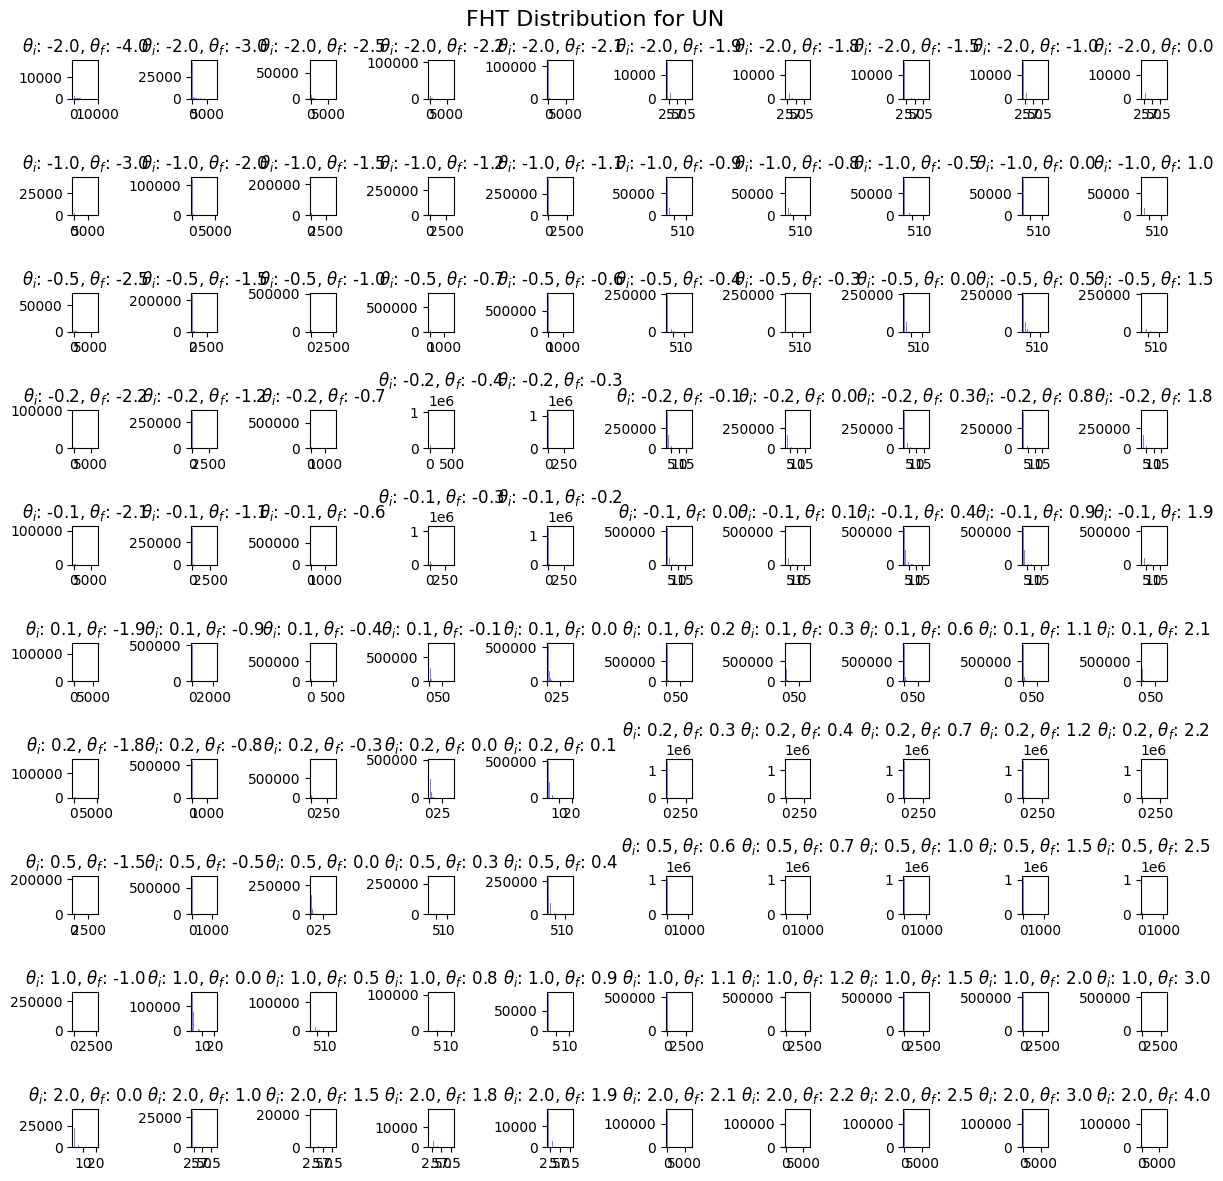

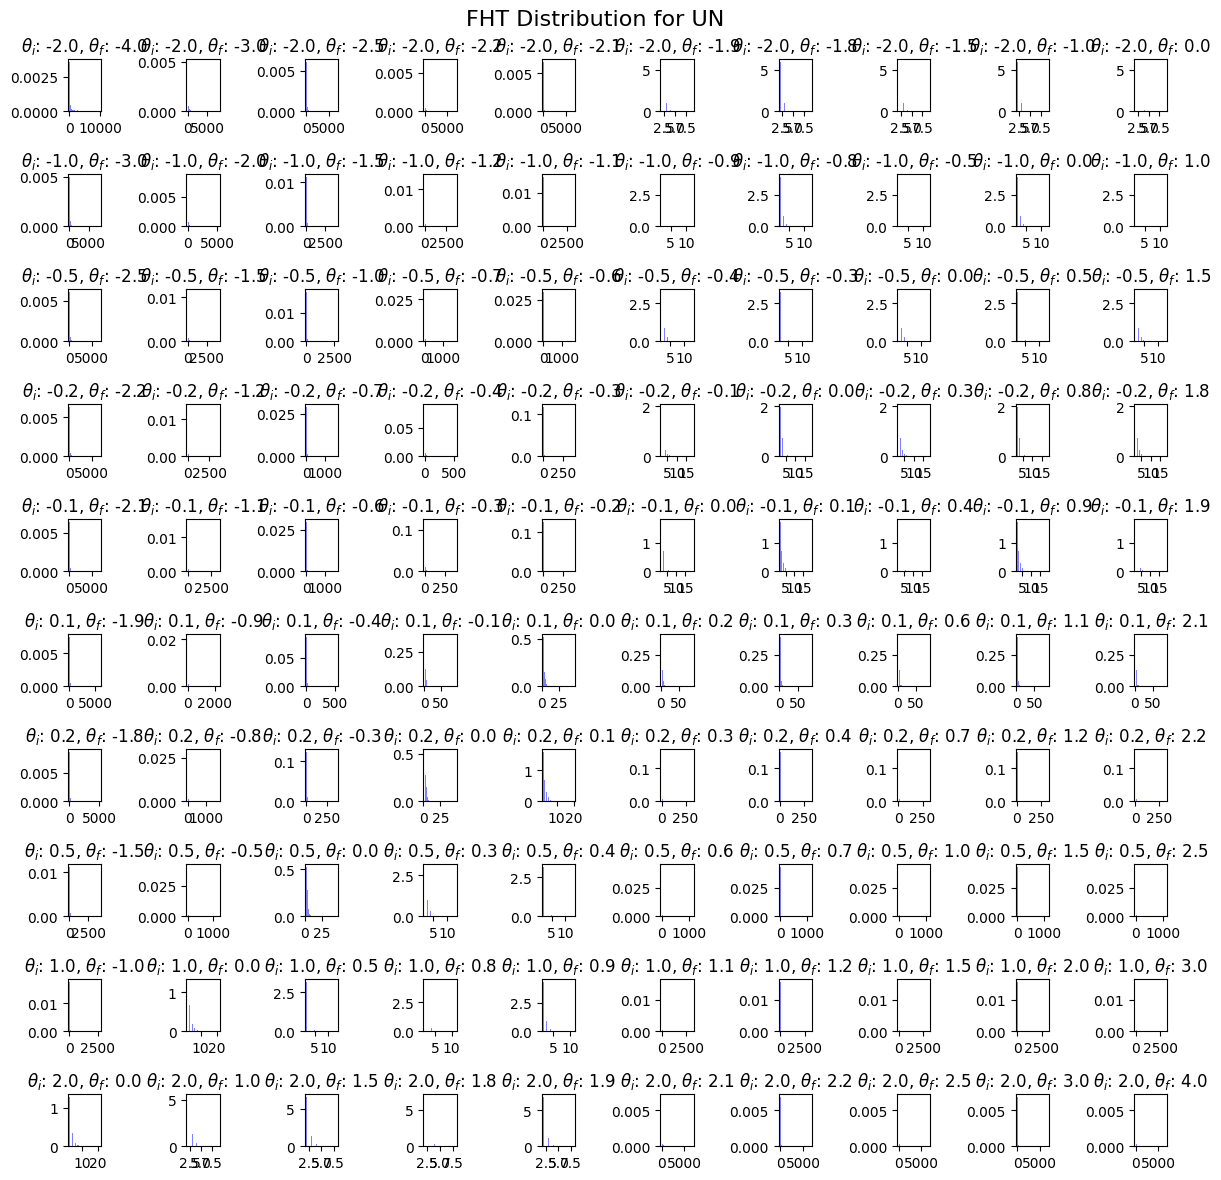

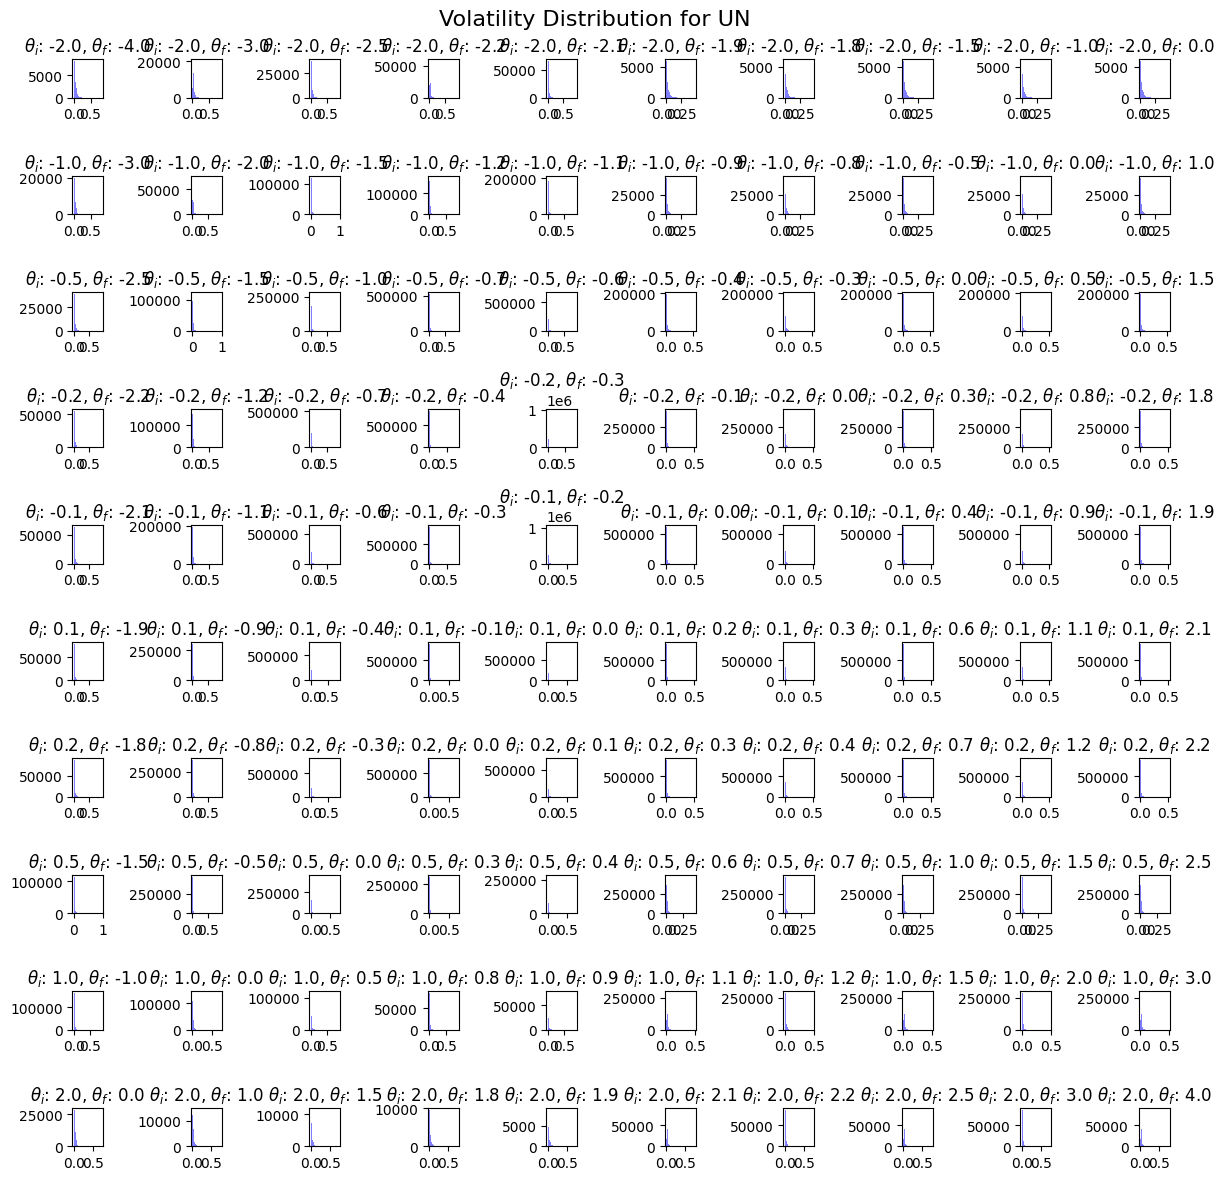

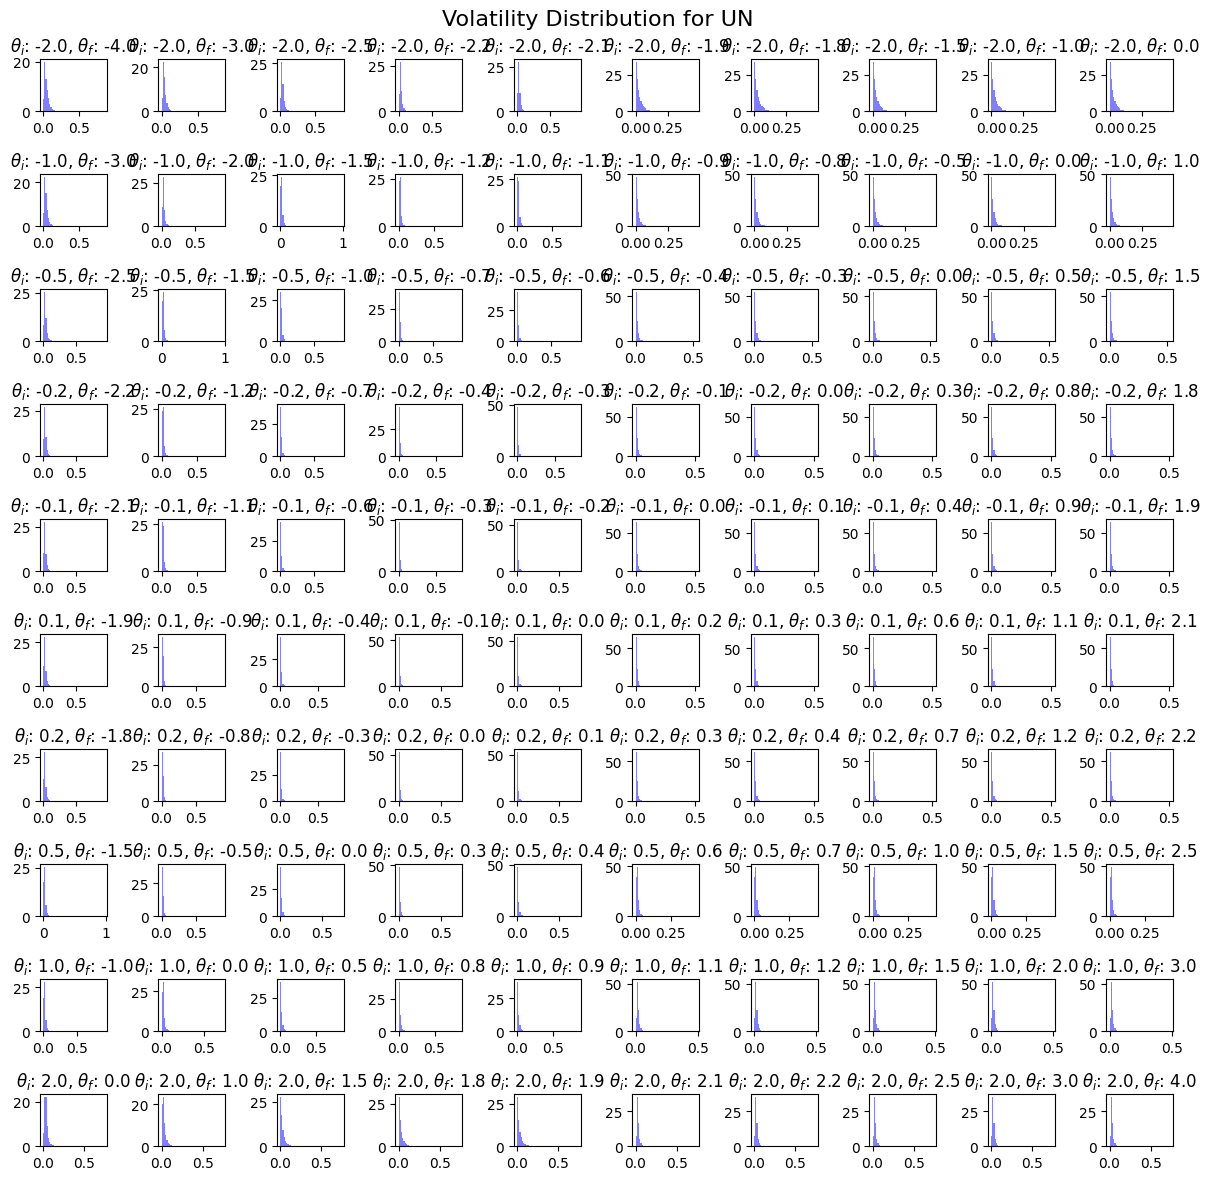

In [5]:
plot_fht_distribution(df_total, "FHT", market, show=False)
plot_fht_distribution(df_total, "FHT", market, density=True, show=False)
plot_fht_distribution(df_total, "Volatility", market, show=False)
plot_fht_distribution(df_total, "Volatility", market, density=True, show=False)

In [6]:
def filter_database_in_notebook(input_db_path, output_db_path, fht_threshold):
    # Connect to the existing database
    conn = sqlite3.connect(input_db_path)
    
    # Get the list of tables in the database
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    
    # Create a new database to store filtered results
    new_conn = sqlite3.connect(output_db_path)
    
    for table_name in tables:
        table_name = table_name[0]
        
        # Query to filter rows where FHT <= fht_threshold
        query = f"SELECT * FROM {table_name} WHERE FHT <= {fht_threshold};"
        
        # Read the filtered data into a DataFrame
        filtered_data = pd.read_sql_query(query, conn)
        
        # If there are any filtered results, write them to the new database
        if not filtered_data.empty:
            filtered_data.to_sql(table_name, new_conn, if_exists='replace', index=False)
    
    # Close the connections
    conn.close()
    new_conn.close()

# Filter the database with a threshold of 30 days
filter_database_in_notebook(DATABASE, DATABASE.parent / "stabilvol_filtered.sqlite", 30)